# <center>Data Mining Project 2 Spring semester 2018-2019</center>
## <center>Παναγιώτης Ευαγγελίου</center>
## <center>Ευάγγελος Σπίθας</center>

___

## Do all the necessary imports for this notebook

In [1]:
import numpy as np
import pandas as pd
import calendar

# visualization
import seaborn as sns
import matplotlib.pyplot as plt

# clustering
from sklearn.cluster import KMeans

In [2]:
%matplotlib inline

## __Read data__

In [3]:
initialDataFrame = pd.read_csv('../data/crime.csv', engine='python')

## __Do some data preparation__

In [4]:
# drop the columns that we don't need
processedDataFrame = initialDataFrame.drop(['Location', 'OFFENSE_DESCRIPTION', 'REPORTING_AREA',
                                            'OCCURRED_ON_DATE', 'UCR_PART', 'STREET'], axis=1)

# replace some NaN values
processedDataFrame = processedDataFrame.fillna({'SHOOTING': "N"})

## __Data Research__

### 1. Count of crimes per year, per month, per date and per district

In [5]:
# groupBy year
yearCountSeries = processedDataFrame.groupby(['YEAR'])['INCIDENT_NUMBER'].count()

# replace month numbers to month names
monthCountDf = processedDataFrame.copy()
monthCountDf['MONTH'] = monthCountDf['MONTH'].apply(lambda x: calendar.month_abbr[x])

# groupBy month
monthCountSeries = monthCountDf.groupby(['MONTH'])['INCIDENT_NUMBER'].count()

# groupBy day
dayCountSeries = processedDataFrame.groupby(['DAY_OF_WEEK'])['INCIDENT_NUMBER'].count()

# groupBy district
districtCountSeries = processedDataFrame.groupby(['DISTRICT'])['INCIDENT_NUMBER'].count()

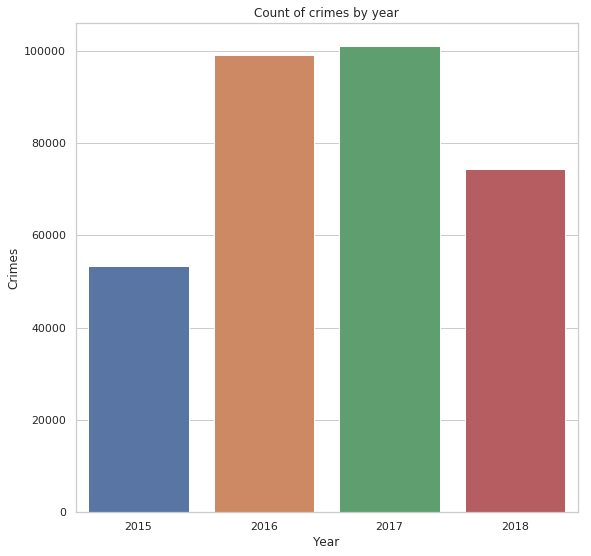

In [6]:
sns.set(style="whitegrid")
plt.figure(figsize=(9, 9))
ax = sns.barplot(x=yearCountSeries.index, y=yearCountSeries.values)
ax.set(title='Count of crimes by year', xlabel='Year', ylabel='Crimes')
plt.show()

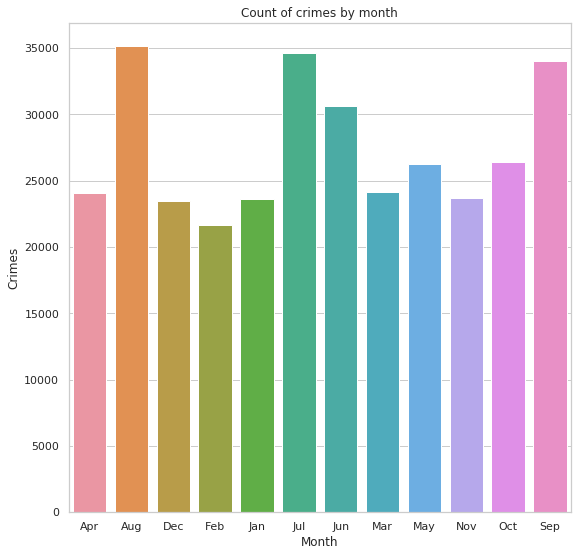

In [7]:
plt.figure(figsize=(9, 9))
ax = sns.barplot(x=monthCountSeries.index, y=monthCountSeries.values)
ax.set(title='Count of crimes by month', xlabel='Month', ylabel='Crimes')
plt.show()

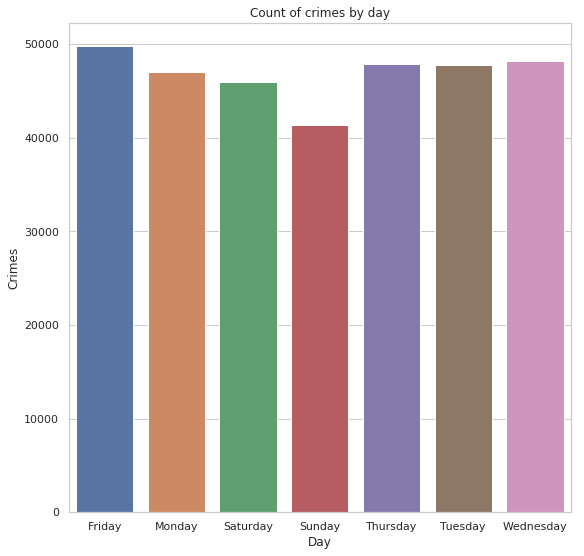

In [8]:
plt.figure(figsize=(9, 9))
ax = sns.barplot(x=dayCountSeries.index, y=dayCountSeries.values)
ax.set(title='Count of crimes by day', xlabel='Day', ylabel='Crimes')
plt.show()

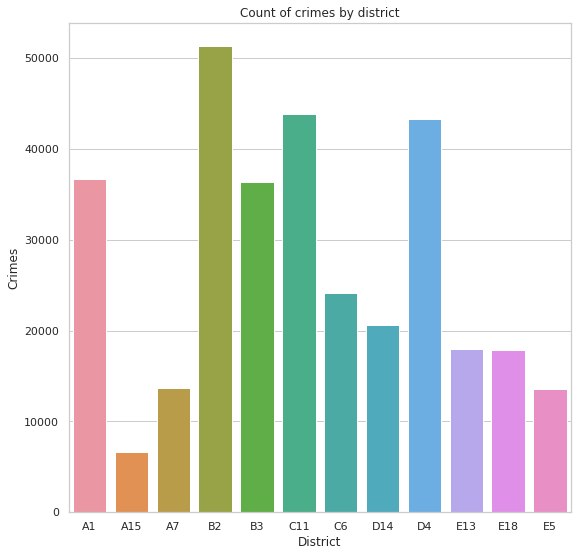

In [9]:
plt.figure(figsize=(9, 9))
ax = sns.barplot(x=districtCountSeries.index, y=districtCountSeries.values)
ax.set(title='Count of crimes by district', xlabel='District', ylabel='Crimes')
plt.show()

 ### 2. Find the maximum count of shootings by year and by district

In [10]:
# replace Y -> 1, N -> 0 so as we can sum the shootings
shootingDataFrame = processedDataFrame.copy()
shootingDataFrame['SHOOTING'] = shootingDataFrame['SHOOTING'].map(dict(Y=1, N=0))

# groupBy year
yearShootings = shootingDataFrame.groupby(['YEAR'])['SHOOTING'].sum()

# groupBy district
districtShootings = shootingDataFrame.groupby(['DISTRICT'])['SHOOTING'].sum()

maxYearSeries = yearShootings[yearShootings == yearShootings.max()]
maxYearOutput = "The year with the most shootings is the year " + str(maxYearSeries.index[0]) + \
                " with " + str(maxYearSeries.values[0]) + " shootings."

maxDistrictSeries = districtShootings[districtShootings == districtShootings.max()]
maxDistrictOutput = "The district with the most shootings is the district " + str(maxDistrictSeries.index[0]) + \
                " with " + str(maxDistrictSeries.values[0]) + " shootings."

print("----------------------------------------------------------------------------")
print(maxYearOutput)
print("----------------------------------------------------------------------------")
print(maxDistrictOutput)
print("----------------------------------------------------------------------------")

----------------------------------------------------------------------------
The year with the most shootings is the year 2017 with 371 shootings.
----------------------------------------------------------------------------
The district with the most shootings is the district B2 with 352 shootings.
----------------------------------------------------------------------------


### 3. Check if crimes are more during the day than during the night

In [11]:
# make new column that represents day or night
dayNightDataFrame = processedDataFrame.copy()
dayNightDataFrame['DAY_NIGHT'] = np.where(((dayNightDataFrame['HOUR'] >= 7) & (dayNightDataFrame['HOUR'] <= 17)),
                                          'day', 'night')

dayCrimesCount = (dayNightDataFrame['DAY_NIGHT'] == 'day').sum()
nightCrimesCount = (dayNightDataFrame['DAY_NIGHT'] == 'night').sum()

if dayCrimesCount > nightCrimesCount:
    print("The number of crimes during the day is more than the number of crimes during the night.")
else:
    print("The number of crimes during the night is more than the number of crimes during the day.")

The number of crimes during the day is more than the number of crimes during the night.


### 4. Find the most common type of crime that is committed during the day

In [12]:
# make a dataFrame that is consisted only of crimes that are committed during the day
onlyDayCrimes = dayNightDataFrame.copy()
onlyDayCrimes = onlyDayCrimes[(onlyDayCrimes['DAY_NIGHT'] == "day")]

# if we need only the name of the code then we can do the following
mostCommonOffenseCode = onlyDayCrimes['OFFENSE_CODE_GROUP'].mode()

# if we want to know the count of crimes of this type then
# groupBy by offense_code
codeCount = onlyDayCrimes.groupby(['OFFENSE_CODE_GROUP'])['INCIDENT_NUMBER'].count()

mostCommonOffenseCodeOutput = "The most common type of crime that is committed during the day is \"" +\
                              str(codeCount[codeCount == codeCount.max()].index[0]) + "\" with " +\
                              str(codeCount[codeCount == codeCount.max()].values[0]) + " crimes."

print(mostCommonOffenseCodeOutput)

The most common type of crime that is committed during the day is "Motor Vehicle Accident Response" with 21852 crimes.


### 5. Clustering based on location

Let's try a scatter plot with seaborn first

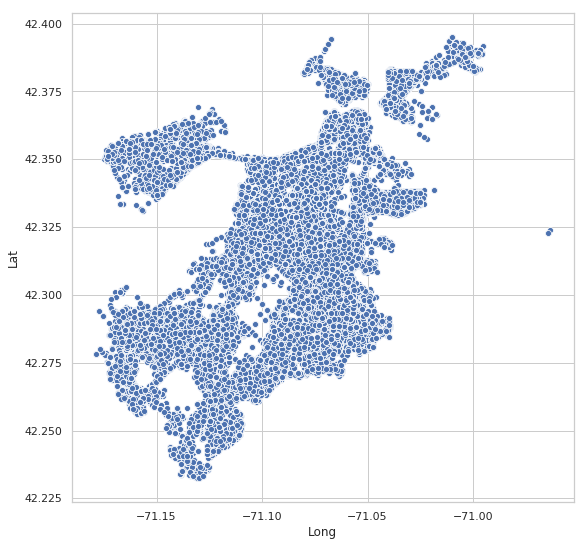

In [13]:
locationDf = processedDataFrame[['Lat', 'Long']]

# remove missing values
locationDf = locationDf.dropna()

specificLocation = locationDf.loc[(locationDf['Lat'] > 40) & (locationDf['Long'] < -60)]

plt.figure(figsize=(9, 9))
ax = sns.scatterplot(x="Long", y="Lat", data=specificLocation)
ax.set(xlabel='Long', ylabel='Lat')
plt.show()

Let's try matplotlib also

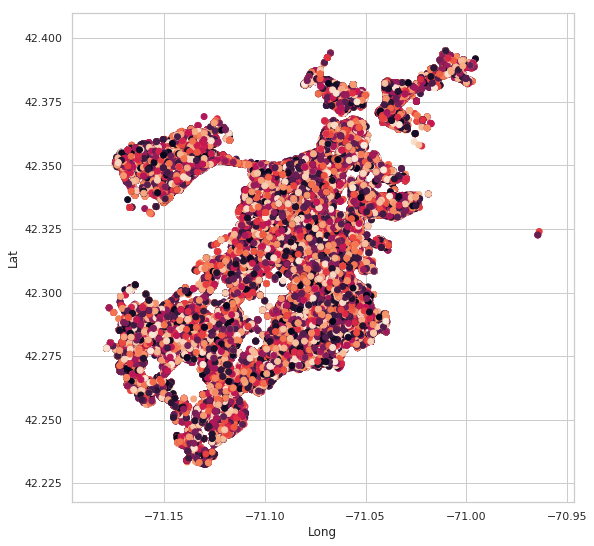

In [14]:
x = specificLocation['Long']
y = specificLocation['Lat']

colors = np.random.rand(len(specificLocation))

plt.figure(figsize=(9, 9))
plt.scatter(x, y, c=colors)
plt.xlabel("Long")
plt.ylabel("Lat")
plt.show()

- #### Let's do the location clustering without extra variables

In [15]:
def KMeansLocationClustering(array, numberOfClusters):
    title = "Location clustering with " + str(numberOfClusters) + " clusters"

    # KMeans
    km = KMeans(n_clusters=numberOfClusters)
    km.fit(array)
    km.predict(array)
    labels = km.labels_

    # Plotting
    plt.figure(figsize=(9, 9))
    plt.scatter(array[:, 1], array[:, 0], c=labels.astype(np.float))
    plt.xlabel("Long")
    plt.ylabel("Lat")
    plt.title(title, fontsize=14)
    plt.show()

In [16]:
locationArray = specificLocation.values

- 2 clusters

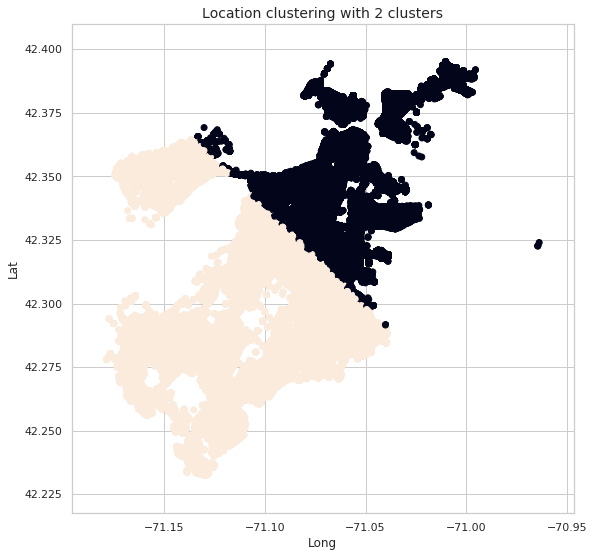

In [17]:
KMeansLocationClustering(locationArray, 2)

- 3 clusters

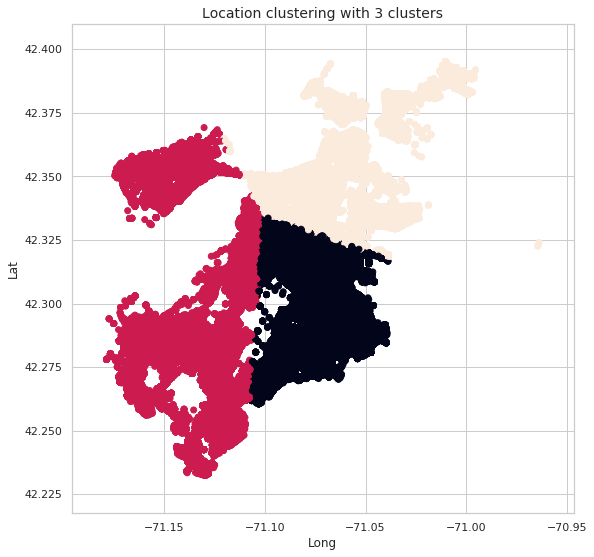

In [18]:
KMeansLocationClustering(locationArray, 3)

- 5 clusters

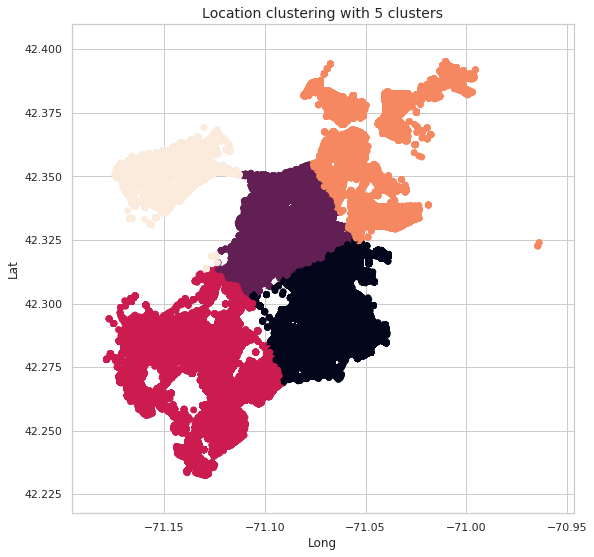

In [19]:
KMeansLocationClustering(locationArray, 5)

- 10 clusters

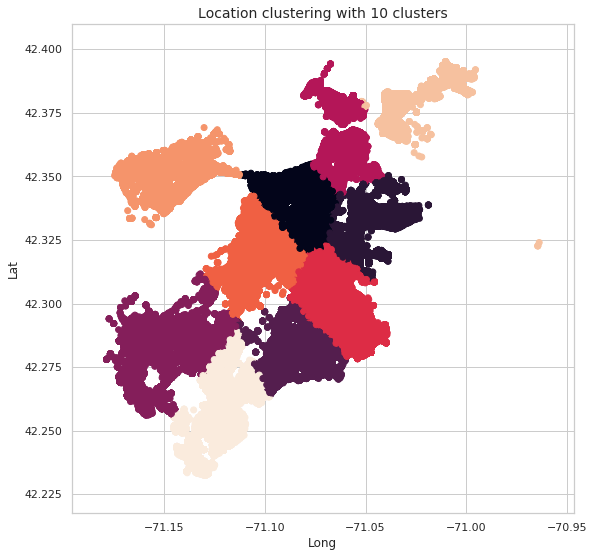

In [20]:
KMeansLocationClustering(locationArray, 10)

- #### Let's do the location clustering with extra variable OFFENSE_CODE

In [21]:
locationDfWithOffenseCode = processedDataFrame[['Lat', 'Long', 'OFFENSE_CODE']]

# remove missing values
locationDfWithOffenseCode = locationDfWithOffenseCode.dropna()

specificLocationOffenseCode = locationDfWithOffenseCode.loc[(locationDfWithOffenseCode['Lat'] > 40)
                                                            & (locationDfWithOffenseCode['Long'] < -60)]

locationArrayOffenseCode = specificLocationOffenseCode.values

- 2 clusters

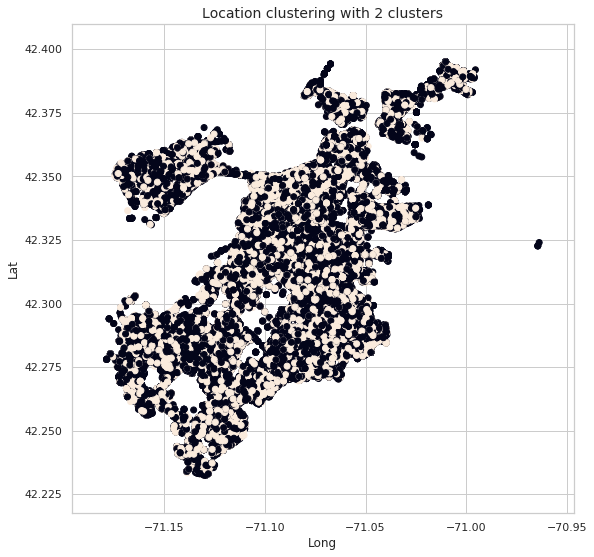

In [22]:
KMeansLocationClustering(locationArrayOffenseCode, 2)

- 3 clusters

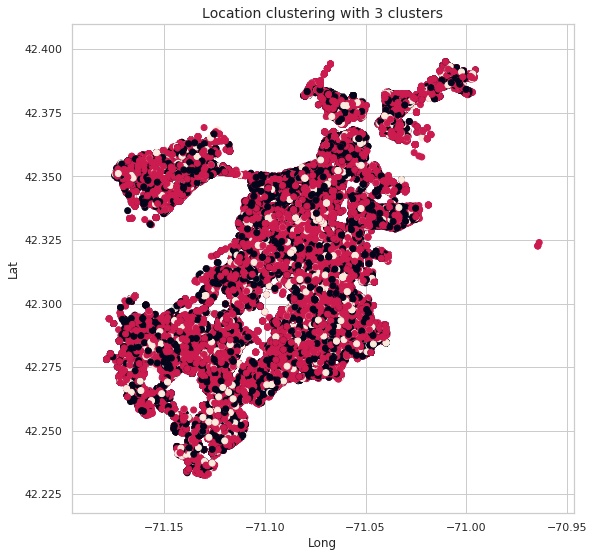

In [23]:
KMeansLocationClustering(locationArrayOffenseCode, 3)

- 5 clusters

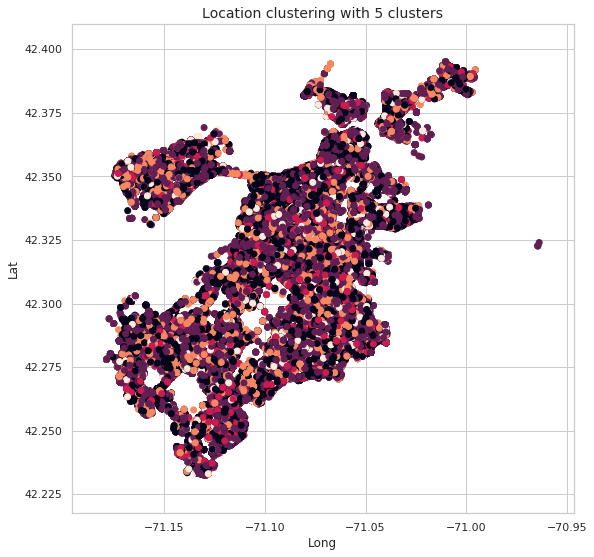

In [24]:
KMeansLocationClustering(locationArrayOffenseCode, 5)

- 10 clusters

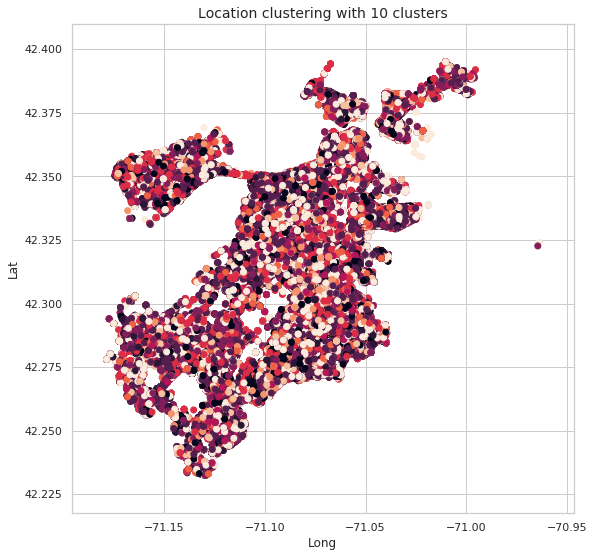

In [25]:
KMeansLocationClustering(locationArrayOffenseCode, 10)

- #### Let's do the location clustering with extra variable MONTH

In [26]:
locationDfWithMonth = processedDataFrame[['Lat', 'Long', 'MONTH']]

# remove missing values
locationDfWithMonth = locationDfWithMonth.dropna()

specificLocationMonth = locationDfWithMonth.loc[(locationDfWithMonth['Lat'] > 40)
                                                & (locationDfWithMonth['Long'] < -60)]

locationArrayMonth = specificLocationMonth.values

- 2 clusters

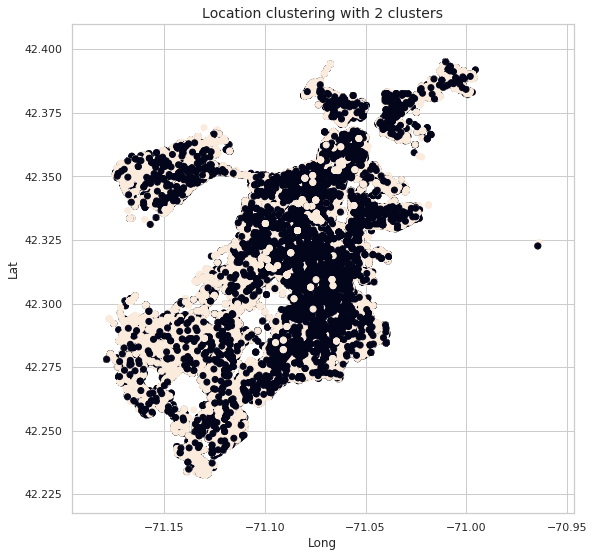

In [27]:
KMeansLocationClustering(locationArrayMonth, 2)

- 3 clusters

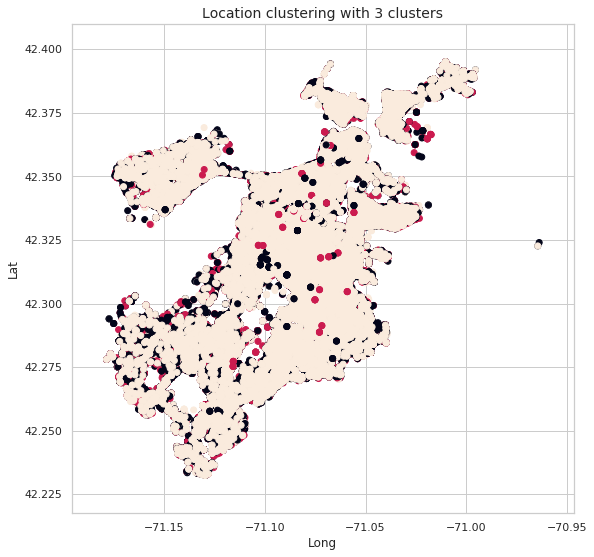

In [28]:
KMeansLocationClustering(locationArrayMonth, 3)

- 5 clusters

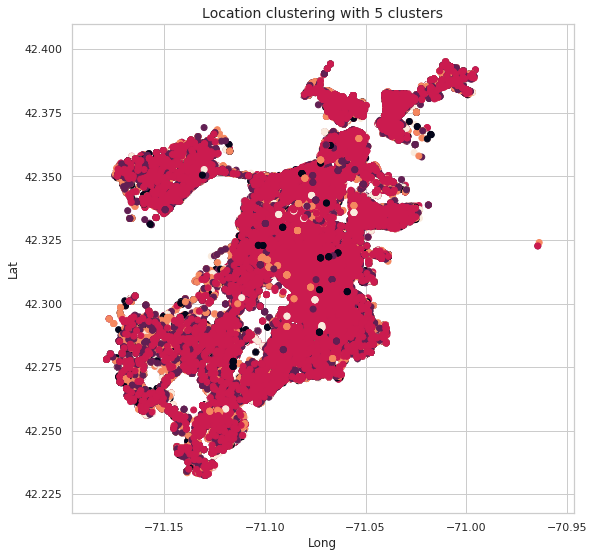

In [29]:
KMeansLocationClustering(locationArrayMonth, 5)

- 10 clusters

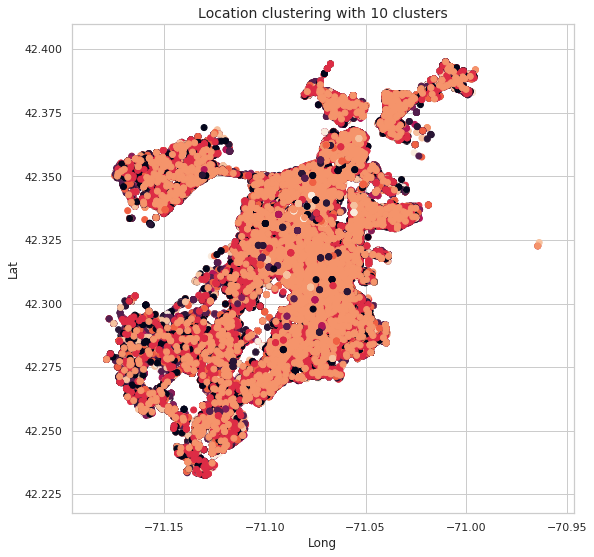

In [30]:
KMeansLocationClustering(locationArrayMonth, 10)